In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from xgboost import XGBRegressor as RandomForestRegressorGPU
from sklearn.linear_model import LinearRegression, Ridge

from scipy.stats import pearsonr
from statsmodels.stats.multitest import fdrcorrection, multipletests

from skimage import color
from matplotlib import cm
from matplotlib.colors import to_rgb, to_rgba #,rgb2hex
from mpl_toolkits.axes_grid1 import make_axes_locatable
from itertools import product


# Loading the datasets. Leaving only the features of interest

In [4]:
bands = {
    "Alpha": pd.read_csv('dmtreg/alpha.csv', header=None),
    "Beta": pd.read_csv('dmtreg/beta.csv', header=None),
    "Delta":  pd.read_csv('dmtreg/delta.csv', header=None),
    "Gamma 1": pd.read_csv('dmtreg/gamma1.csv', header=None),
    "Gamma 2": pd.read_csv('dmtreg/gamma2.csv', header=None),
    "Theta": pd.read_csv('dmtreg/theta.csv', header=None),
    "DMT Alpha": pd.read_csv('dmtreg/DMT_alpha.csv', header=None),
    "DMT Beta": pd.read_csv('dmtreg/DMT_beta.csv', header=None),
    "DMT Delta": pd.read_csv('dmtreg/DMT_delta.csv', header=None),
    "DMT Gamma 1": pd.read_csv('dmtreg/DMT_gamma1.csv', header=None),
    "DMT Gamma 2": pd.read_csv('dmtreg/DMT_gamma2.csv', header=None),
    "DMT Theta": pd.read_csv('dmtreg/DMT_theta.csv', header=None)
}

labels = list(pd.read_csv("dmtreg/target_labels.txt", header=None)[0])
targets = pd.read_csv('dmtreg/target.csv', header=None)
targets.columns = labels

scale_results = pd.read_csv("dmtreg/scales_results.csv", index_col=0).reset_index(drop=True)

scale_results_columns = ['BFI1-E', 'BFI1-A', 'BFI1-C', 'BFI1-N', 'BFI1-O', 'BFI2-E', 'BFI2-A', 'BFI2-C', 'BFI2-N', 'BFI2-O', 'TAS1', 'TAS2']

scale_results = scale_results[scale_results_columns].drop([2, 5, 8, 16, 23, 31])

for band_name in bands:
    bands[band_name] = pd.concat([bands[band_name], scale_results], axis=1)



# Define useful functions

In [12]:
cmap = plt.get_cmap('plasma')

def to_gray(x):
  # RGBA to RGB
  rgba = cm.twilight_shifted(x)
  rgb = to_rgb(rgba)
  # RGB to Gray
  gray = color.rgb2gray(np.asarray(rgb))
  return cm.gray(gray)


def PlotCorr(band, fdr=True, alpha=0.1, pvalue=0.05):
  rpearson_matrix = np.zeros((12,20))
  pvalues_matrix = np.ones((12,20))
  corr_matrix = np.zeros((4,12,20))

  for roi, score in product(range(12), range(20)):
    array1 = band.iloc[:,roi].to_numpy()
    array2 = targets.iloc[:,score].to_numpy()
    r, p = pearsonr(array1, array2)
    rpearson_matrix[roi,score] = abs(r)
    pvalues_matrix[roi,score] = p
    corr_matrix[:, roi,score] = to_rgba(cm.plasma(r))

  max_value = np.max(rpearson_matrix)
  min_value = np.min(rpearson_matrix)

  scaler = MinMaxScaler()
  scaler.fit(rpearson_matrix)
  rpearson_matrix = scaler.transform(rpearson_matrix)
  for roi, score in product(range(12), range(20)):
   r = rpearson_matrix[roi,score]
   corr_matrix[:, roi,score] = to_rgba(cm.plasma(r))

  if fdr==False:
    #
    for roi, score in product(range(12), range(20)):
      if pvalues_matrix[roi,score] > pvalue:
        corr_matrix[:, roi,score] = to_gray(rpearson_matrix[roi,score])

  if fdr==True:
    p_corrected = fdrcorrection(pvalues_matrix.flatten(),alpha=alpha)[0].reshape(12,20)
    for roi, score in product(range(12), range(20)):
      if p_corrected[roi,score] != True:
        corr_matrix[:,roi,score] = to_gray(rpearson_matrix[roi,score])

  fig, ax = plt.subplots(figsize=(15,8))
  im = ax.imshow(np.transpose(corr_matrix))

  ax.set_xticks(np.arange(12))
  ax.set_yticks(np.arange(20))

  ax.set_xticklabels(scale_results_columns, fontsize=10, rotation='vertical')
  #plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
  ax.set_yticklabels(targets.columns[:-3], fontsize=10)

  #norm = plt.Normalize(radii[0], radii[-1])
  m = plt.cm.ScalarMappable(cmap=cmap) #norm
  m.set_array([min_value, max_value])
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="1%", pad=0.07)
  plt.colorbar(m, cax=cax).set_label('r Pearson', size=15)

  plt.show()
  #return matrix

# Correlation Analysis

Without FDR and p = 0.05


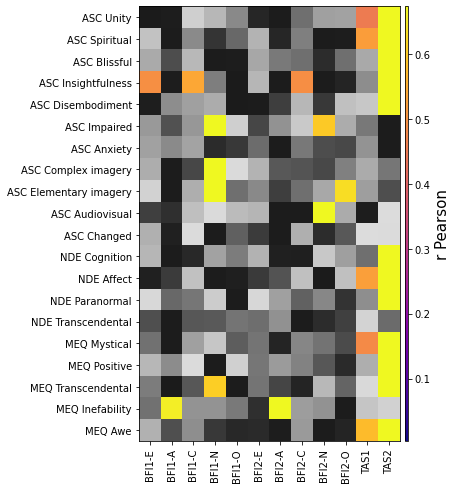

With FDR and alpha = 0.1


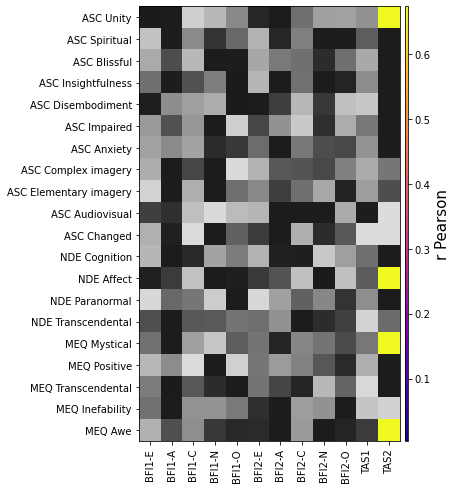

In [17]:
print("Without FDR and p = 0.05")
PlotCorr(scale_results, fdr=False, pvalue=0.05)
print("With FDR and alpha = 0.1")
PlotCorr(scale_results, fdr=True, alpha=0.1)

# Random Forest Regression

In [3]:
reg = RandomForestRegressorGPU(n_estimators=500,
                            max_depth=8,
                            #booster='gbtree',
                            objective='reg:squarederror',
                            tree_method='gpu_hist',
                            gpu_id=0)

reg_s = RandomForestRegressorGPU(n_estimators=500,
                            max_depth=8,
                            #booster='gbtree',
                            objective='reg:squarederror',
                            tree_method='gpu_hist',
                            gpu_id=0)


reg = RandomForestRegressor(n_estimators=500,
                            max_depth=8)

reg_s = RandomForestRegressor(n_estimators=500,
                            max_depth=8)

scaler = StandardScaler()

history = []

for target in range(targets.shape[1]):
    for band_name, band in bands.items():
      r2_list = []
      rpearson_list = []
      y_pred_list = []
      y_true_list = []

      r2_list_s = []
      rpearson_list_s = []
      y_pred_list_s = []
      y_true_list_s = []

      X = np.array(band)
      y = np.array(targets.iloc[:,target])
      target_name = targets.iloc[:,target].name
      
      print(target_name,"-",band_name)
    
      for i in range(200): 
        X_train, X_test, y_train, y_test, y_train_s, y_test_s = train_test_split(X, y, shuffle(y), test_size=0.2)

        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        y_train = scaler.fit_transform(y_train.reshape(-1,1))
        y_test = scaler.transform(y_test.reshape(-1,1))
        y_train_s = scaler.fit_transform(y_train_s.reshape(-1,1))
        y_test_s = scaler.transform(y_test_s.reshape(-1,1))

        reg.fit(X_train, np.ravel(y_train))

        y_pred = reg.predict(X_test)
        y_true = np.ravel(y_test)
        r2 = r2_score(y_true, y_pred)
        r, pvalue = pearsonr(y_true, y_pred)
        r2_list.append(r2)
        rpearson_list.append(r)
        y_pred_list.append(y_pred)
        y_true_list.append(y_true)

        reg_s.fit(X_train, np.ravel(y_train_s))

        y_pred_s = reg_s.predict(X_test)
        y_true_s = np.ravel(y_test_s)
        r2_s = r2_score(y_true_s, y_pred_s)
        r_s, pvalue_s = pearsonr(y_true_s, y_pred_s)
        r2_list_s.append(r2_s)
        rpearson_list_s.append(r_s)
        y_pred_list_s.append(y_pred_s)
        y_true_list_s.append(y_true_s)

      dictio = {
        "Target": target_name,
        "Band": band_name,
        "R2": r2_list,
        "r Pearson": rpearson_list,
        "y_pred": y_pred_list,
        "y_true": y_true_list,
        "y_pred Shuffle": y_pred_list_s,
        "pvalue": pvalue,
        "pvalue_s": pvalue_s
        }
      
      r_mean = sum(rpearson_list)/len(rpearson_list)
      print("r mean:", r_mean,"\n")
      dictio["r_mean"] = r_mean
      history.append(dictio)

all_pvalues = [item["pvalue"] for item in history] + [item["pvalue_s"] for item in history]

reject, pvals_corrected, _, _ = multipletests(all_pvalues, method='fdr_bh')

for i in range(len(history)):
    history[i]["pvalue_corrected"] = pvals_corrected[i]
    history[i]["pvalue_s_corrected"] = pvals_corrected[i + len(history)]

      
history_df = pd.DataFrame(history)
history_df.to_csv('random_forest_regression_results_combined.csv', index=False)

ASC Unity - Alpha
r mean: 0.24487951839502017 

ASC Unity - Beta
r mean: 0.13118359247479675 

ASC Unity - Delta
r mean: 0.06520223699036831 

ASC Unity - Gamma 1
r mean: 0.11106606439143878 

ASC Unity - Gamma 2
r mean: 0.17190380823697535 

ASC Unity - Theta
r mean: 0.3559673863222094 

ASC Unity - DMT Alpha
r mean: 0.019183165913191767 

ASC Unity - DMT Beta
r mean: 0.15242652520899302 

ASC Unity - DMT Delta
r mean: -0.12905146680450028 

ASC Unity - DMT Gamma 1
r mean: -0.18695522760110278 

ASC Unity - DMT Gamma 2
r mean: -0.2081715500770734 

ASC Unity - DMT Theta
r mean: 0.3014149927799062 

ASC Spiritual - Alpha
r mean: 0.1815157925516286 

ASC Spiritual - Beta
r mean: 0.17375328568904078 

ASC Spiritual - Delta
r mean: -0.19508130445500751 

ASC Spiritual - Gamma 1
r mean: -0.1986172463648156 

ASC Spiritual - Gamma 2
r mean: -0.07264018340884919 

ASC Spiritual - Theta
r mean: 0.38036514700360774 

ASC Spiritual - DMT Alpha
r mean: -0.08705840234200724 

ASC Spiritual - DMT 

c:\Users\zhivk\anaconda3\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


r mean: 0.4588507916122988 

Post Setting - Gamma 1
r mean: 0.18718654667856677 

Post Setting - Gamma 2
r mean: 0.13877681327826472 

Post Setting - Theta
r mean: 0.3101020414899073 

Post Setting - DMT Alpha
r mean: 0.5143266922056798 

Post Setting - DMT Beta
r mean: -0.15043715815412578 

Post Setting - DMT Delta
r mean: 0.17441110823355033 

Post Setting - DMT Gamma 1
r mean: 0.19384107120185945 

Post Setting - DMT Gamma 2
r mean: 0.23355243721708835 

Post Setting - DMT Theta
r mean: 0.21946692689000485 



# Linear Regression


In [ ]:

lr = LinearRegression()
lr_s = LinearRegression()

scaler = StandardScaler()

kf = KFold(n_splits=5, shuffle=True, random_state=42)

history = []

for target in range(targets.shape[1]):
    for band_name, band in bands.items():
        r2_list = []
        rpearson_list = []
        y_pred_list = []
        y_true_list = []

        r2_list_s = []
        rpearson_list_s = []
        y_pred_list_s = []
        y_true_list_s = []

        X = np.array(band)
        y = np.array(targets.iloc[:,target])
        target_name = targets.iloc[:,target].name
      
        print(target_name,"-",band_name)
        

        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
            y_train = scaler.fit_transform(y_train.reshape(-1, 1))
            y_test = scaler.transform(y_test.reshape(-1, 1))

            # Use GridSearchCV for finding the best alpha value
            lr.fit(X_train, np.ravel(y_train))

            y_train_s = np.random.permutation(y_train)  # Shuffle the labels for the shuffled model

            lr.fit(X_train, np.ravel(y_train))
            lr_s.fit(X_train, np.ravel(y_train_s))

            y_pred = lr.predict(X_test)
            y_true = np.ravel(y_test)
            r2 = r2_score(y_true, y_pred)
            r, pvalue = pearsonr(y_true, y_pred)
            r2_list.append(r2)
            rpearson_list.append(r)
            y_pred_list.append(y_pred)
            y_true_list.append(y_true)

            y_pred_s = lr_s.predict(X_test)
            y_true_s = np.ravel(y_test)
            r2_s = r2_score(y_true_s, y_pred_s)
            r_s, pvalue_s = pearsonr(y_true_s, y_pred_s)
            r2_list_s.append(r2_s)
            rpearson_list_s.append(r_s)
            y_pred_list_s.append(y_pred_s)
            y_true_list_s.append(y_true_s)

        dictio = {
            "Target": target_name,
            "Band": band_name,
            "R2": r2_list,
            "r Pearson": rpearson_list,
            "y_pred": y_pred_list,
            "y_true": y_true_list,
            "R2 Shuffle": r2_list_s,
            "r Pearson Shuffle": rpearson_list_s,
            "y_pred Shuffle": y_pred_list_s,
            "y_true Shuffle": y_true_list_s
        }

        r_mean = sum(rpearson_list)/len(rpearson_list)
        dictio["r_mean"] = r_mean
        print("r mean:", r_mean,"\n")

        history.append(dictio)

history_df = pd.DataFrame(history)

history_df.to_csv('linear_regression_results_combined.csv', index=False, )

# Ridge Regression

In [ ]:

ridge = Ridge()
ridge_s = Ridge()

scaler = StandardScaler()

history = []

# Define the alpha values for Ridge Regression
parameters = {'alpha': np.linspace(0.1, 1, 30)}

# Set up KFold cross-validator with 5 splits
kf = KFold(n_splits=5, shuffle=True)

for target in range(targets.shape[1]):
    for band_name, band in bands.items():
        r2_list = []
        rpearson_list = []
        y_pred_list = []
        y_true_list = []

        r2_list_s = []
        rpearson_list_s = []
        y_pred_list_s = []
        y_true_list_s = []

        X = np.array(band)
        y = np.array(targets.iloc[:, target])
        target_name = targets.iloc[:, target].name

        print(target_name, "-", band_name)

        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
            y_train = scaler.fit_transform(y_train.reshape(-1, 1))
            y_test = scaler.transform(y_test.reshape(-1, 1))

            # Use GridSearchCV for finding the best alpha value
            grid = GridSearchCV(ridge, parameters, cv=kf, scoring='r2')
            grid.fit(X_train, np.ravel(y_train))
            best_alpha = grid.best_params_['alpha']
            ridge.alpha = best_alpha
            ridge_s.alpha = best_alpha

            y_train_s = np.random.permutation(y_train)  # Shuffle the labels for the shuffled model

            ridge.fit(X_train, np.ravel(y_train))
            ridge_s.fit(X_train, np.ravel(y_train_s))

            y_pred = ridge.predict(X_test)
            y_true = np.ravel(y_test)
            r2 = r2_score(y_true, y_pred)
            r, pvalue = pearsonr(y_true, y_pred)
            r2_list.append(r2)
            rpearson_list.append(r)
            y_pred_list.append(y_pred)
            y_true_list.append(y_true)

            y_pred_s = ridge_s.predict(X_test)
            y_true_s = np.ravel(y_test)
            r2_s = r2_score(y_true_s, y_pred_s)
            r_s, pvalue_s = pearsonr(y_true_s, y_pred_s)
            r2_list_s.append(r2_s)
            rpearson_list_s.append(r_s)
            y_pred_list_s.append(y_pred_s)
            y_true_list_s.append(y_true_s)

        dictio = {
            "Target": target_name,
            "Band": band_name,
            "R2": r2_list,
            "r Pearson": rpearson_list,
            "y_pred": y_pred_list,
            "y_true": y_true_list,
            "R2 Shuffle": r2_list_s,
            "r Pearson Shuffle": rpearson_list_s,
            "y_pred Shuffle": y_pred_list_s,
            "y_true Shuffle": y_true_list_s
        }


        r_mean = sum(rpearson_list)/len(rpearson_list)
        dictio["r_mean"] = r_mean
        print("r mean:", r_mean,"\n")

        history.append(dictio)

history_df = pd.DataFrame(history)

history_df.to_csv('ridge_regression_results_combined.csv', index=False)

# Polynomial Features

In [ ]:

# Create PolynomialFeatures object
poly = PolynomialFeatures(degree=2)

lr = LinearRegression()
lr_s = LinearRegression()

scaler = StandardScaler()

kf = KFold(n_splits=5, shuffle=True, random_state=42)

history = []

for target in range(targets.shape[1]):
    for band_name, band in bands.items():
        r2_list = []
        rpearson_list = []
        y_pred_list = []
        y_true_list = []

        r2_list_s = []
        rpearson_list_s = []
        y_pred_list_s = []
        y_true_list_s = []

        X = np.array(band)
        y = np.array(targets.iloc[:,target])
        target_name = targets.iloc[:,target].name
      
        print(target_name,"-",band_name)
        

        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # Transform the data to polynomial features
            X_train_poly = poly.fit_transform(X_train)
            X_test_poly = poly.transform(X_test)

            # Scale the data
            X_train = scaler.fit_transform(X_train_poly)
            X_test = scaler.transform(X_test_poly)
            y_train = scaler.fit_transform(y_train.reshape(-1, 1))
            y_test = scaler.transform(y_test.reshape(-1, 1))

            # Fit and predict
            lr.fit(X_train, np.ravel(y_train))

            y_train_s = np.random.permutation(y_train)  # Shuffle the labels for the shuffled model

            lr.fit(X_train, np.ravel(y_train))
            lr_s.fit(X_train, np.ravel(y_train_s))

            y_pred = lr.predict(X_test)
            y_true = np.ravel(y_test)
            r2 = r2_score(y_true, y_pred)
            r, pvalue = pearsonr(y_true, y_pred)
            r2_list.append(r2)
            rpearson_list.append(r)
            y_pred_list.append(y_pred)
            y_true_list.append(y_true)

            y_pred_s = lr_s.predict(X_test)
            y_true_s = np.ravel(y_test)
            r2_s = r2_score(y_true_s, y_pred_s)
            r_s, pvalue_s = pearsonr(y_true_s, y_pred_s)
            r2_list_s.append(r2_s)
            rpearson_list_s.append(r_s)
            y_pred_list_s.append(y_pred_s)
            y_true_list_s.append(y_true_s)

        dictio = {
            "Target": target_name,
            "Band": band_name,
            "R2": r2_list,
            "r Pearson": rpearson_list,
            "y_pred": y_pred_list,
            "y_true": y_true_list,
            "R2 Shuffle": r2_list_s,
            "r Pearson Shuffle": rpearson_list_s,
            "y_pred Shuffle": y_pred_list_s,
            "y_true Shuffle": y_true_list_s
        }

      
        r_mean = sum(rpearson_list)/len(rpearson_list)
        dictio["r_mean"] = r_mean
        print("r mean:", r_mean,"\n")

        history.append(dictio)

history_df = pd.DataFrame(history)

history_df.to_csv('poly_regression_results_combined.csv', index=False)